# budo_to_ontology

This file explains the original code `budo_to_ontology` from Yingying Yang. The new version `jsonld_budo_to_ontology` from Belén Llopis takes the same functions and tools but changes the way the data is imported (instead of Excel it is with jsonld). Almost all the functions are maintained with some modifications, and only the ones from the tool `OnWithData` are removed. Thus, it has to be considered that the following explanations are from the original code without jsonld. 

First, libraries ar imported in Python.

When using only `ontology_to_modelica` (not with _CoTeTo-GUI_), comment 

```python
from ebc_sql import EbcSql
```
and uncomment 

```python
from  CoTeTo.ebc_sql import EbcSql
```

In [3]:
from rdflib import RDFS, RDF, Namespace, Graph, URIRef, Literal
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from StyleFrame import StyleFrame 
from openpyxl import load_workbook
import xlrd
import os
import scipy as sci
import seaborn as sns
from modelicares import SimRes
#from  CoTeTo.ebc_sql import EbcSql
from ebc_sql import EbcSql 
from collections import OrderedDict
import datetime as dt
import numpy as np
import modelicares
import tkinter

Then, it is inizialized the graph. It is called:

- RDFS and RDF
- BRICK (Brick Tagsets). E.g., Temperature_Sensor is a subclass of Sensor
- BF (Brick relationships). E.g., sensor1 is a point of vav1.
- BUDO. Git link of the repository of this project.

In [4]:
 # Initialize a graph
RDFS # predefined namespace as 'http://www.w3.org/2000/01/rdf-schema#'
RDF # predefined namespace as 'http://www.w3.org/1999/02/22-rdf-syntax-ns#'
BRICK = Namespace('https://brickschema.org/schema/1.0.3/Brick#')
BF = Namespace('https://brickschema.org/schema/1.0.3/BrickFrame#')
EX = Namespace('http://example.com#')
BUDO = Namespace('https://git.rwth-aachen.de/EBC/Team_BA/misc/Machine-Learning/tree/master/building_ml_platform/BUDO-M#')              


## budo_to_graph function

It uses other functions explained below:

- generate_brick_budo_dic
- generate_connect_dic
- add_port
- create_data_property_dataframe
- delete_repeated_medium_property
- add_boundary_condition_to_dataframe
- add_relationship


In [5]:
               
def budo_to_graph(path):
 # Combine all functions in loops to read BUDO Keys from Excel file and generate BrickModel
    g = Graph()
    g.bind('ex', EX)
    g.bind('brick', BRICK)
    g.bind('bf', BF)
    g.bind('rdfs', RDFS)
    g.bind('rdf', RDF)
    g.bind('budo', BUDO)
    (brick_dict,budo_dict)=generate_brick_budo_dic()
    data = xlrd.open_workbook(path)
    table = data.sheet_by_name(u'setup')
    zone = table.cell(2,0).value
    points=table.cell(2,1).value.split(',')
    equipments=table.cell(2,2).value.split(',')      
    points_dic={}
    equipments_dic={}
    data={'tag':[],'BUDO':[],'parameter':[],'value':[],'unit':[],'explanation':[]}
    pt = pd.read_excel(path, sheet_name='BUDO Key')
    for row in pt.iterrows():
        budo_split=str(row[1][0]).split('_')
        if budo_split[2].split('-')[1] == zone and  len(budo_split[3].split('-'))>1:
           if budo_split[3].split('-')[1] in points:
                point=budo_split[3].split('-')[1]
                instance=str(row[1][0])
                points_dic[point]=instance
                key=budo_split[-2].split('.')[0]
                if key in brick_dict.keys():
                    tag=brick_dict[key]
                elif key=='MEA':
                    key=budo_split[-2]
                    tag=brick_dict[key]
                g.add((EX[instance], RDF.type,  BRICK[tag]))
                g.add((EX[instance], BUDO['itemID'],Literal(str(row[1][1]))))
                data=create_data_property_dataframe(points_dic[point],tag,data)
           elif budo_split[3].split('-')[1] in equipments:
               equipment=budo_split[3].split('-')[1]
               if budo_split[-1] in["AI","AO","BI","BO"]:
                    instance=str(row[1][0])
                    key=budo_split[3].split('-')[0].split('.')[0]
                    if equipment not in equipments_dic.keys():
                        equipments_dic[equipment]='_'.join(budo_split[0:-2])                                      
                        if key in brick_dict.keys():
                            tag=brick_dict[key]
                        else:
                            key=budo_split[2].split('-')[0].split('.')[0]
                            tag=brick_dict[key]
                        g.add((EX[equipments_dic[equipment]], RDF.type, BRICK[tag]))
                        g=add_port(equipments_dic[equipment],tag,g)
                        data=create_data_property_dataframe(equipments_dic[equipment],tag,data)
                    key=budo_split[-2].split('.')[0]
                    tag=brick_dict[key]
                    g.add((EX[instance], RDF.type,  BRICK[tag]))
                    g.add((EX[instance], BUDO['itemID'],Literal(str(row[1][1]))))
                    g.add((EX[equipments_dic[equipment]], BF.hasPoint, EX[instance])) 
               else:
                    equipments_dic[equipment]=str(row[1][0])
                    key=budo_split[3].split('-')[0].split('.')[0]
                    if key in brick_dict.keys():
                        tag=brick_dict[key]
                        g.add((EX[equipments_dic[equipment]], RDF.type, BRICK[tag]))
                    elif key in budo_dict.keys():
                        tag=budo_dict[key]
                        g.add((EX[equipments_dic[equipment]], RDF.type, BUDO[tag]))
                    else:
                        key=budo_split[2].split('-')[0].split('.')[0]
                        tag=brick_dict[key]
                        g.add((EX[equipments_dic[equipment]], RDF.type, BRICK[tag]))
                    g=add_port(equipments_dic[equipment],tag,g)
                    data=create_data_property_dataframe(equipments_dic[equipment],tag,data)
#    print(equipments_dic)
#    print(points_dic)    
    connect_dic=generate_connect_dic(path)
#    print(connect_dic)
    g=add_relationship(g,connect_dic,equipments_dic,points_dic)    
    data=add_boundary_condition_to_dataframe(g,data)
    dataframe=delete_repeated_medium_property(data,g)
    return g,dataframe

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 25)

### generate_brick_budo_dic


This function creates two dictionaries: brick_dict and budo_dict. 

The first one stores the class in BRICK and the corresponding acronym in BUDO (of some components), and the second one stores the class in BUDO and the acronym in BUDO (right now this second one only stores the T-piece, which I think has something to do with this:
_[...]the tool-chain requires the building’s BMS system to have very complete data points. However, some mechanical component such as T-piece usually has no data points associated with them. Therefore, there is no relevant BUDO Key in the process of modelling. As a result, users have to manually add the corresponding BUDO Key in the InputDataFile according to the rules of the BUDO Key, so that the established model is consistent with the real system.[...]_).

File is read from the excel _mapping_ (sheet DICTIONARY) in path _Machine-Learning\building_ml_platform\BUDO-M\Platform_Application_AI_Buildings_MA_Ying\OntologyToModelica\CoTeTo\Loaders\Auxiliary_).

This is written like 

```python
os.path.join(os.path.dirname(os.path.realpath(__file__)),'Loaders/Auxiliary/mapping.xlsx'
```
which means that it is joined (os.path.join) the path where the script is:

```python
os.path.dirname(os.path.realpath(__file__)
```
where `__file__` refers to the script file name and `(Loaders/Auxiliary/mapping.xlsx)` where the file is located, so the path is complete.

Dictionaries created:



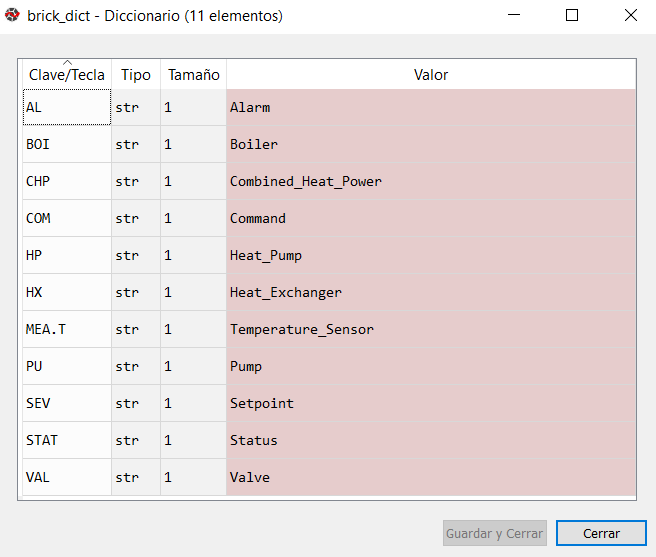

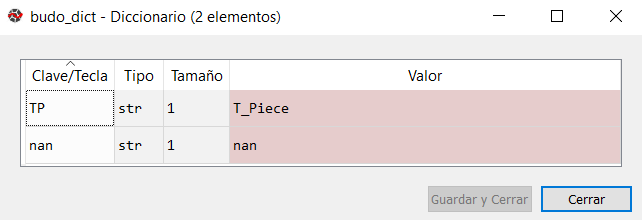

In [6]:
def generate_brick_budo_dic():
#reading mapping rules of BUDO Keys to Brick Schema and BUDO-M ontologies, and storing them in dictionaries
    brick_dict={}
    budo_dict={}
    pt = pd.read_excel(os.path.join(os.path.dirname(os.path.realpath(__file__)),'Loaders/Auxiliary/mapping.xlsx'), sheet_name="DICTIONARY")
    for row in pt.iterrows():
        brick_dict[str(row[1][1])]=str(row[1][0])
        budo_dict[str(row[1][3])]=str(row[1][2])
    return brick_dict,budo_dict


### generate_connect_dic

This function reads data from *initial.xlsx*, the sheet "setup". This means that `path` is where `initial.xlsx` is located. It reads connections between components and stores them in dictionary:



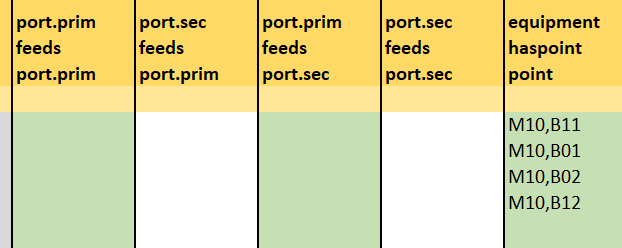


It only reads in this columns of the "setup" excel sheet. `connect_dic`creates the dictionary, `connect_key` the list of keys of that dictionary. `iterrows` gives an iterator for reading in each row, so it reads on each row and column of these four columns and writes in the corresponding key a list of what is read in the cell (the connexions).
Take into account that the values of each key are **lists**.

If results in the following dictionary:

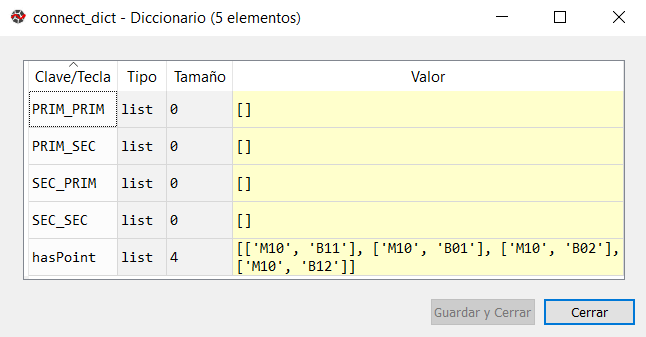

In [ ]:
def generate_connect_dic(path):
#reading connections between components and storing them in dictionary
    connect_dic={'PRIM_PRIM':[],
                     'SEC_PRIM':[],
                     'PRIM_SEC':[],
                     'SEC_SEC':[],
                     'hasPoint':[]}
    connect_key=['PRIM_PRIM','SEC_PRIM','PRIM_SEC','SEC_SEC','hasPoint']
    pt = pd.read_excel(path, sheet_name='setup')
    for row in pt.iterrows():
        for i in range(3,8):
            if str(row[1][i])!="nan":
                pair=str(row[1][i]).split(",")
                connect_dic[connect_key[i-3]].append(pair)
    return connect_dic             

### add_port

In [ ]:
def add_port(instance,tag,g):
#adding port to components
    if ('MX' in instance or 'DIV' in instance)or 'Heat_Pump' in tag or 'Heat_Exchanger'in tag:
        g.add((EX[instance+'_PH.PRIM'], RDF.type, BUDO['portHeatflow.prim']))
        g.add((EX[instance], BF.hasPart, EX[instance+'_PH.PRIM']))
        g.add(( EX[instance+'_PH.SEC'], RDF.type, BUDO['portHeatflow.sec']))
        g.add((EX[instance], BF.hasPart, EX[instance+'_PH.SEC']))
    else:
        g.add(( EX[instance+'_PH'], RDF.type, BUDO['portHeatflow']))
        g.add((EX[instance], BF.hasPart,  EX[instance+'_PH']))
    if 'DIV' in instance:
        g.add(( EX[instance+'_PH.SEC'], BF.isFedBy, EX[instance+'_PH.PRIM']))  
    if 'MX' in instance: 
        g.add(( EX[instance+'_PH.SEC'], BF.feeds, EX[instance+'_PH.PRIM']))  
    return g

### create_data_property_dataframe

In [ ]:
def create_data_property_dataframe(instance,tag,data):
#generating dataproperties for components and storing them in dataframe
    gf = Graph()
    gf.bind('brick', BRICK)
    gf.bind('ex', EX)
    gf.bind('budo', BUDO) 
    gf.parse(os.path.join(os.path.dirname(os.path.realpath(__file__)),'Loaders/Auxiliary/BRICK/Brick.ttl'), format='turtle')
    gf.parse(os.path.join(os.path.dirname(os.path.realpath(__file__)),'Loaders/Auxiliary/BUDO_M/BUDO-M.ttl'), format='turtle')
    ExcelSheet=['BRICK','BUDO']
    ports_ontology=['portHeatflow.prim','portHeatflow.sec','portHeatflow.ter']
    ports_budokey=['PH.PRIM','PH.SEC','PH.TER']
    for ontology in ExcelSheet:
        pt = pd.read_excel(os.path.join(os.path.dirname(os.path.realpath(__file__)),'Loaders/Auxiliary/mapping.xlsx'), sheet_name=ontology)
        for row in pt.iterrows():
            classes=str(row[1][0])
            if ontology=='BRICK':
                res=gf.query("""ASK{brick:%s rdfs:subClassOf*  brick:%s }""" %(tag,classes))
            else:
                res=gf.query("""ASK{budo:%s rdfs:subClassOf*  budo:%s }""" %(tag,classes))
            if res:
                if str(row[1][5])!='nan':
                    data_property=str(row[1][5]).split('/')
                    data_unit=str(row[1][6]).split(',')
                    data_explanation=str(row[1][7]).split('/')
                    for (properties,units,explanations) in zip(data_property,data_unit,data_explanation):
                        data['tag'].append(tag)
                        data['BUDO'].append(instance)
                        data['parameter'].append(properties)
                        data['value'].append("None")
                        data['unit'].append(units)
                        data['explanation'].append(explanations)
                for i in range (0,row[1][4]):
                    if classes=='Valve'and (not('DIV' in instance or 'MX' in instance)):
                        break
                    if str(row[1][8])!='nan':
                        if row[1][4]==1:
                            port_tag='portHeatflow'
                            port_key='PH'
                        else:
                            port_tag=ports_ontology[i]
                            port_key=ports_budokey[i]
                        port_data_property=str(row[1][8]).split('/')
                        port_data_unit=str(row[1][9]).split(',')
                        port_data_explanation=str(row[1][10]).split('/')
                        for (properties,units,explanations) in zip(port_data_property,port_data_unit,port_data_explanation):      
                            data['tag'].append( port_tag)
                            data['BUDO'].append(instance+'_'+port_key)
                            data['parameter'].append(properties)
                            data['value'].append("None")
                            data['unit'].append(units)
                            data['explanation'].append(explanations)
    return data

### delete_repeated_medium_property

It uses other functions explained below:

- check_medium_property_repeatation



In [ ]:
def delete_repeated_medium_property(data,g):
#deleting repeated declaration of data property medium in one fluid system
    df = pd.DataFrame(data)
    medium_list=[]
    drop_list=[]
    for index, row in df.iterrows():
        if row["parameter"]=='medium':
            medium_repeated=check_medium_property_repeatation(g,row["tag"],medium_list,row["BUDO"])
            if medium_repeated:
               drop_list.append(index)
            else:
                medium_list.append(row["BUDO"])
    df_final=df.drop(drop_list)
    return df_final    

### check_medium_property_repeatation


In [ ]:
def check_medium_property_repeatation(g,tag,medium_list,instance): 
#finding repeated declaration of data property medium in one fluid system
    if "portHeatflow" in tag:
        rows=g.query( """SELECT ?o WHERE{  { ex:%s bf:feeds*  ?o.}union{  ex:%s bf:isFedBy* ?o.}union {{  ex:%s bf:feeds*  ?e.}union{  ex:%s bf:isFedBy* ?e.} ?e bf:hasPoint ?o.}} """ %(instance,instance,instance,instance))
    else:
        rows=g.query( """SELECT ?o WHERE{ ex:%s bf:isPointOf ?a.  {?a bf:feeds*  ?o.}union{ ?a bf:isFedBy* ?o.}union {{ ?a bf:feeds*  ?e.}union{ ?a bf:isFedBy* ?e.} ?e bf:hasPoint ?o.}} """ %(instance))
    m = {'http://example.com':''}
    res = [[m[r.split('#')[0]]+ r.split('#')[1] if isinstance(r, URIRef) and '#' in r else r for r in row] for row in rows]
    medium_repeated=False
    for row in res:        
        if row[0] in medium_list:
            medium_repeated=True 
    return medium_repeated

### add_boundary_condition_to_dataframe

Until this one is used in __budo_to_graph__ function

In [ ]:
def add_boundary_condition_to_dataframe(g,data): 
# finding our boundaries of systems, adding boundary data properties into dataframe
    rows = g.query("""SELECT ?s WHERE {?m bf:hasPart ?s. MINUS {?s bf:isFedBy ?n.}}""")
    m = {'http://example.com':'',}
    res = [[m[r.split('#')[0]]+ r.split('#')[1] if isinstance(r, URIRef) and '#' in r else r for r in row] for row in rows] 
    ports_dict={'PH.PRIM':'portHeatflow.prim','PH.SEC':'portHeatflow.sec','PH.TER':'portHeatflow.ter','PH':'portHeatflow'}
    for equipment in res: 
         for item in equipment:
             for properties,explanations,units in zip(['boundarypath.temperature','boundarypath.massflow'],['mat file directory for boundary condition temperature when needed','mat file directory for boundary condition massflow when needed'],['K','kg/s']):
                data['tag'].append(ports_dict[item.split('_')[-1]])
                data['BUDO'].append(item)
                data['parameter'].append(properties)
                data['value'].append("None")
                data['unit'].append(units)
                data['explanation'].append(explanations)
    return data           

## create_data_property_excel

In [ ]:
def create_data_property_excel(dataframe,sheet_name,path): 
#writing content of data property dataframe into a new Excel file
    writer = StyleFrame.ExcelWriter(path)    
    sf = StyleFrame(dataframe)
    sf.set_column_width(columns=['tag', 'BUDO','parameter','explanation','value'], width=60)
    sf.to_excel(writer,sheet_name)
    writer.save()
    writer.close()

## add_data_property_excelsheet

In [ ]:
def add_data_property_excelsheet(dataframe,sheet_name,path): 
#writing content of data property dataframe into a new worksheet of an Excel file
    writer = StyleFrame.ExcelWriter(path)    
    book = load_workbook(writer.path)
    writer.book = book
    sf = StyleFrame(dataframe)
    sf.set_column_width(columns=['tag', 'BUDO','parameter','explanation','value'], width=60)
    sf.to_excel(writer,sheet_name)
    writer.save()
    writer.close()

## read_data_property_excel

In [ ]:
def read_data_property_excel(g,path='data_property.xlsx'):
#reading data properties values from Excel file and combine them into BrickModel with Data Property relationship
    data_property= pd.read_excel(path)
    for row in data_property.iterrows():
        if str(row[1][5])!="None":            
            g.add((EX[str(row[1][0])], BUDO[str(row[1][2])],  Literal(str(row[1][5]))))
    return g

## add_relationship

In [ ]:
def add_relationship(g,connect_dic,equipments_dic,points_dic):
#Adding relationship between components
    for relationship in connect_dic.keys():
        if relationship=="hasPoint":
           for item in connect_dic[relationship]:
               if (len(equipments_dic[item[0]].split("_"))==4 and (equipments_dic[item[0]].split("_")[2].split('-')[0].split('.')[0] in ['HP','HX'])) or 'DIV' in equipments_dic[item[0]] or 'MX' in equipments_dic[item[0]] :#BUDO                  
                   if  'HP' in equipments_dic[item[0]] and "WS.H" in points_dic[item[1]]:
                       g.add((EX[equipments_dic[item[0]]+'_PH.PRIM'], BF["hasPoint"], EX[points_dic[item[1]]]))
                   if  'HP' in equipments_dic[item[0]] and "WS.CH" in points_dic[item[1]]:
                       g.add((EX[equipments_dic[item[0]]+'_PH.SEC'], BF["hasPoint"], EX[points_dic[item[1]]])) 
                   if  ('HX' in equipments_dic[item[0]] or  'DIV' in equipments_dic[item[0]] or 'MX' in equipments_dic[item[0]])and "PRIM" in points_dic[item[1]]:
                       g.add((EX[equipments_dic[item[0]]+'_PH.PRIM'], BF["hasPoint"], EX[points_dic[item[1]]]))
                   if  ('HX' in equipments_dic[item[0]] or  'DIV' in equipments_dic[item[0]] or 'MX' in equipments_dic[item[0]]) and "SEC" in points_dic[item[1]]:
                       g.add((EX[equipments_dic[item[0]]+'_PH.SEC'], BF["hasPoint"], EX[points_dic[item[1]]]))
               else:                   
                   g.add((EX[equipments_dic[item[0]]+'_PH'], BF["hasPoint"], EX[points_dic[item[1]]]))
        else:
            for item in connect_dic[relationship]:
                relate=relationship.split('_')
                if (len(equipments_dic[item[0]].split("_"))==4 and ('HX' in equipments_dic[item[0]] or 'HP' in equipments_dic[item[0]])) or 'DIV' in equipments_dic[item[0]] or 'MX' in equipments_dic[item[0]]:
                    port_out=equipments_dic[item[0]]+'_PH.'+relate[0]
                else:
                    port_out=equipments_dic[item[0]]+'_PH'
                if (len(equipments_dic[item[1]].split("_"))==4 and ('HX' in equipments_dic[item[1]] or 'HP' in equipments_dic[item[1]])) or 'DIV' in equipments_dic[item[1]] or 'MX' in equipments_dic[item[1]]:
                    port_in=equipments_dic[item[1]]+'_PH.'+relate[1]
                else:
                    port_in=equipments_dic[item[1]]+'_PH'                  
                g.add((EX[port_out], BF["feeds"], EX[port_in]))
    g=add_reverse_relationship(g)
    return g

## add_reverse_relationship

In [ ]:
def add_reverse_relationship(g):
#Adding reverse relationships between components
    res = g.query("SELECT ?a ?b WHERE { ?a bf:hasPart ?b .}")
    for row in res:
        g.add((row[1], BF.isPartOf, row[0]))
    res = g.query("SELECT ?a ?b WHERE { ?a bf:isPartOf ?b .}")
    for row in res:
        g.add((row[1], BF.hasPart, row[0]))
    
    res = g.query("SELECT ?a ?b WHERE {?a bf:hasPoint ?b .}")
    for row in res:
        g.add((row[1], BF.isPointOf, row[0]))
    res = g.query("SELECT ?a ?b WHERE {?a bf:isPointOf ?b .}")
    for row in res:
        g.add((row[1], BF.hasPoint, row[0]))
    
    res = g.query("SELECT ?a ?b WHERE {?a bf:feeds ?b .}")
    for row in res:
        if '_'.join(row[1].split('_')[0:-1])!='_'.join(row[0].split('_')[0:-1]):
            g.add((row[1], BF.isFedBy, row[0]))
    res = g.query("SELECT ?a ?b WHERE {?a bf:isFedBy ?b .}")
    for row in res:
        if '_'.join(row[1].split('_')[0:-1])!='_'.join(row[0].split('_')[0:-1]):
            g.add((row[1], BF.feeds, row[0]))
    
    res = g.query("SELECT ?a ?b WHERE {?a bf:contains ?b .}")
    for row in res:
        g.add((row[1], BF.isLocatedIn, row[0]))
    res = g.query("SELECT ?a ?b WHERE {?a bf:isLocatedIn ?b .}")
    for row in res:
        g.add((row[1], BF.contains, row[0]))
    
    res = g.query("SELECT ?a ?b WHERE {?a bf:controls ?b .}")
    for row in res:
        g.add((row[1], BF.isControlledBy, row[0]))
    res = g.query("SELECT ?a ?b WHERE {?a bf:isControlledBy ?b .}")
    for row in res:
        g.add((row[1], BF.controls, row[0]))
    
    res = g.query("SELECT ?a ?b WHERE {?a bf:hasOutput ?b .}")
    for row in res:
        g.add((row[1], BF.isOutputOf, row[0]))
    
    res = g.query("SELECT ?a ?b WHERE {?a bf:hasInput ?b .}")
    for row in res:
        g.add((row[1], BF.isInputOf, row[0]))
    
    res = g.query("SELECT ?a ?b WHERE {?a bf:hasTagSet ?b .}")
    for row in res:
        g.add((row[1], BF.isTagSetOf, row[0]))
    
    res = g.query("SELECT ?a ?b WHERE {?a bf:hasToken ?b .}")
    for row in res:
        g.add((row[1], BF.isTokenOf, row[0]))
    
    return g

## print_graph

In [ ]:
def print_graph(g):
#print contents of BrickModel
    g_str = g.serialize(format='turtle').decode('utf-8')
    print(g_str)

## query_result

In [ ]:
def query_result(rows):
#processing result of SPARQL query
    m = {
        'https://brickschema.org/schema/1.0.3/Brick': 'brick',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns': 'rdf',
        'http://www.w3.org/2000/01/rdf-schema': 'rdfs',
        'https://brickschema.org/schema/1.0.3/BrickFrame': 'bf',
        'http://www.w3.org/2002/07/owl': 'owl',
        'http://www.w3.org/2004/02/skos/core': 'skos',
        'http://example.com': 'ex',
        'https://git.rwth-aachen.de/EBC/Team_BA/misc/Machine-Learning/tree/master/building_ml_platform/BUDO-M':'budo'
        }
    res = [[m[r.split('#')[0]] + ':' + r.split('#')[1] if isinstance(r, URIRef) and '#' in r else r for r in row] for row in rows]
    return res
    

## visualization

In [ ]:
def visualization(g):
# visualization of the BrickModel
    q1 = """select ?s ?p ?o where {?s ?p ?o .}"""
    q2 = """select ?s where {?o rdfs:subClassOf* brick:Point. ?s rdf:type ?o}"""
    q3 = """select ?s where {{?o rdfs:subClassOf* brick:Equipment. ?s rdf:type ?o} UNION{?o rdfs:subClassOf* budo:pipeFitting. ?s rdf:type ?o}} """
    q4 = """select ?s where {?o rdfs:subClassOf* brick:Location. ?s rdf:type ?o}"""
    q5 = """select ?s where {?o rdfs:subClassOf* budo:Port. ?s rdf:type ?o}"""
    rows = g.query(q1)
    res=query_result(rows)
    G = nx.DiGraph()    
    for row in res:
        if 'ex' in row[2]:
            G.add_edge(row[0], row[2],predicate=row[1]) 
    g.parse(os.path.join(os.path.dirname(os.path.realpath(__file__)),'Loaders/Auxiliary/BRICK/Brick.ttl'), format='turtle') 
    g.parse(os.path.join(os.path.dirname(os.path.realpath(__file__)),'Loaders/Auxiliary/BUDO_M/BUDO-M.ttl'), format='turtle')
    query_list=[q2,q3,q4,q5]
    color_choice=['green','red','yellow','black']
    i=0
    for q in query_list:        
        rows = g.query(q)
        res=query_result(rows)
        for row in res:   
            G.node[row[0]]['color'] = color_choice[i]
        i=i+1
#        print(G.nodes(data=True))  
    colors=[]
    for node,attribute in tuple (G.nodes(data=True)):  
        if 'color'in attribute:
            colors.append(attribute['color'])
        else:
            colors.append('pink')
    nx.draw(G,pos=nx.spring_layout(G),with_labels=True, edge_color='b',node_size=300, node_color = colors,arrows=True,width=0.3,font_family='sans-serif', alpha=0.5, font_size=4)        
#    plt.savefig(path, dpi =2000)
    plt.show()

## get_points

In [ ]:
def get_points(class_name,g,ontology,u):   
#SPARQL queries for finding out instance belonging to given classes   
    g.parse(os.path.join(os.path.dirname(os.path.realpath(__file__)),'Loaders/Auxiliary/BRICK/Brick.ttl'), format='turtle')
    g.parse(os.path.join(os.path.dirname(os.path.realpath(__file__)),'Loaders/Auxiliary/BUDO_M/BUDO-M.ttl'), format='turtle')
    if ontology=="BRICK":
        rows = g.query("""
        SELECT ?s
        WHERE {
            ?p rdf:type owl:Class.
            ?p rdfs:subClassOf* brick:%s .
            ?s rdf:type ?p .
           
        }
        """ %(class_name))
    else:
        rows = g.query("""
        SELECT ?s
        WHERE {
            ?p rdf:type owl:Class.
            ?p rdfs:subClassOf* budo:%s .
            ?s rdf:type ?p .
        }
        """ %(class_name)) 
    m = {
        'https://brickschema.org/schema/1.0.3/Brick': 'brick',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns': 'rdf',
        'http://www.w3.org/2000/01/rdf-schema': 'rdfs',
        'https://brickschema.org/schema/1.0.3/BrickFrame': 'bf',
        'http://www.w3.org/2002/07/owl': 'owl',
        'http://www.w3.org/2004/02/skos/core': 'skos',
        'http://example.com': '',
        'https://git.rwth-aachen.de/EBC/Team_BA/misc/Machine-Learning/tree/master/building_ml_platform/BUDO-M':'budo'
        }
    res = [[m[r.split('#')[0]] + r.split('#')[1] if isinstance(r, URIRef) and '#' in r else r for r in row] for row in rows]
    return res

## ask_if_model_with_pipe

In [10]:
def ask_if_model_with_pipe():
#ask user choices, if generating model with pipe lines
    root = tkinter.Tk()
    root.title("")
    screenwidth = root.winfo_screenwidth()
    screenheight = root.winfo_screenheight()
    size = '%dx%d+%d+%d' % (250, 150, (screenwidth - 250)/2, (screenheight - 150)/2)
    root.geometry(size)    
    group = tkinter.LabelFrame(root,text = 'Generate model with pipeline?',padx = 5,pady = 5)
    group.pack(padx = 10,pady = 10)
    options = ['Yes','No']
    v = tkinter.StringVar()
    v.set('Yes')
    for choice in options:
        tkinter.Radiobutton(group,text =choice,variable = v,value = choice).pack(anchor = tkinter.W)
    tkinter.Button(root, text ="confirm",command=root.destroy).pack()
    root.mainloop()
    choice=v.get()    
    return choice       

## generate_boundary_condition_file


It uses other functions:
- convert_value
- 

This is the `BouGen` tool. It reads data from SQL database and writes it into _mat_ File according to user requirements in Excel File.

`xlrd.open_workbook` opens the workbook and `sheet_by_name` selects the proper sheet. `cell(2,8)` means row 3 and column I in Excel (it is zero indexed).

In [ ]:
def generate_boundary_condition_file(inputpath,outputpath):
# reading data from SQL database and writing them into mat File according to user requirements in Excel File
    data = xlrd.open_workbook(inputpath)
    table = data.sheet_by_name(u'setup')
    time_start = str(table.cell(2,8).value)
    time_end=str(table.cell(2,9).value)
    pt = pd.read_excel(inputpath, sheet_name='setup')
    for row in pt.iterrows():
        if str(row[1][10])!="nan":
            key='_'.join(str(row[1][10]).split('_')[0:4])
            itemID=int(row[1][11])
            (value_mea,time_mea,time_mea_date_form)=load_mea_result(key,itemID,time_start,time_end) 
            value_mea=convert_value(str(row[1][12]),str(row[1][13]),value_mea)          
            matrix_name='data' 
            matrix=np.column_stack([value_mea.index, value_mea])
            output='/'.join(outputpath.split(".")[0].split('/')[0:-1])+'/'+str(row[1][11])+'.mat'
            sci.io.savemat(output,{matrix_name:matrix})   

## convert_value

In [ ]:
def convert_value (plus,multiply,value):
#altering units of data
    if plus!="nan":
        value=value+float(plus)
    if multiply!="nan":
        value=value*float(multiply)
    return value

## load_sim_result

In [ ]:
def load_sim_result(simrespath,variable):
#loading simulation results
    sims, __ = modelicares.load(simrespath)
    value_sim = sims[variable].values()
    time_sim=sims[variable].times()
    value_sim=value_sim[0]
    time_sim=time_sim[0]
    return value_sim,time_sim

## load_mea_result

In [ ]:
def load_mea_result(budo_key,itemID,time_start,time_end):
#loading measured data from databases
    path_to_config = os.path.join(os.path.dirname(os.path.realpath(__file__)),"res/settings_standard.ini")
    option_groups = "odbc_from"
    connection = EbcSql(option_files=path_to_config,option_groups=option_groups)
    connection.set_standard(option_files=path_to_config,option_groups=["ts_database_from", "format"])
    time_start_df=dt.datetime.strptime(time_start, "%Y-%m-%d %H:%M:%S")
    ids_ordered_dict = OrderedDict([(itemID,budo_key)])        
    data = connection.get_timeseries_df(ids=ids_ordered_dict,
                                        time_start=time_start,
                                        time_end=time_end,
                                        sort_by="ts_time_column",
                                        sort_order="ASC",
                                        use_query=True,
                                        get_last_value_before=True,
                                        replace_first_index=True)
    value_mea=data[budo_key]
    value_mea.index = (value_mea.index-time_start_df).total_seconds()
    time_mea=(data.index-time_start_df).total_seconds()
    time_mea_date_form = data.index
    return value_mea,time_mea,time_mea_date_form

## reshape_mea_result

In [ ]:
def reshape_mea_result(value_mea,time_mea,time_sim):
#interploting measured data in order to have the same scope with the simulated data.
    tck =sci.interpolate.splrep(time_mea, value_mea)
    value_mea = sci.interpolate.splev(time_sim,tck)
    return value_mea

## plot_sim_graph

In [ ]:
def plot_sim_graph(setuppath,simrespath=None):
#print the graph of simulationsresult and measured data
    data = xlrd.open_workbook(setuppath)
    table = data.sheet_by_name(u'setup')
    time_start = str(table.cell(2,8).value)
    time_end=str(table.cell(2,9).value)
    pt = pd.read_excel(setuppath, sheet_name='result plot')        
    for row in pt.iterrows():
        if str(row[1][1])!="nan":
            sns.set_palette("muted")
            sns.set_style("whitegrid")
            key='_'.join(str(row[1][1]).split('_')[0:4])
            itemID=int(row[1][2])
            (value_mea,time_mea,time_mea_date_form)=load_mea_result(key,itemID,time_start,time_end)  
            value_mea=convert_value(str(row[1][3]),str(row[1][4]),value_mea)
            if  str(row[1][0])=="nan": 
                plt.plot(time_mea_date_form, value_mea, label=str(row[1][1]))                               
            else: 
                variable=str(row[1][0])  
                value_sim,time_sim=load_sim_result(simrespath,variable)
#                value_mea=reshape_mea_result(value_mea,time_mea,time_sim)
                plt.plot(time_mea, value_mea, label=str(row[1][1]))
                plt.plot(time_sim, value_sim, label=str(row[1][1])+'_SIM')
            axes=plt.gca()
            #            axes.set_ylim([0, 40])
            for tick in axes.xaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
            for tick in axes.yaxis.get_major_ticks():
                tick.label.set_fontsize(20)     
            for tick in axes.get_xticklabels():
                tick.set_rotation(0)
            axes.legend(prop={'size': 20})
            plt.xlabel("time (in s)", fontsize = 32)
            plt.ylabel("temperature (in °C)", fontsize = 32)            
            font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 35}            
            mpl.rc('font', **font)
            fig=plt.gcf()
            fig.set_size_inches(18.5, 10.5, forward=True)
            plt.show()
            if  str(row[1][0])!="nan":       
                plt.figure()
#            fig.savefig('simulation_results.png', dpi=fig.dpi, bbox_inches='tight')    

## RMSE

In [ ]:
def RMSE(value_mea,value_sim):
    """root mean square error"""
    rmse=np.sqrt(((value_mea-value_sim) ** 2).mean())
    return rmse

## MAE

In [ ]:
def MAE(value_mea,value_sim):
    """mean absolute error"""
    mea=abs(value_mea-value_sim).mean()
    return mea

## NRMSE

In [ ]:
def NRMSE(value_mea,value_sim):
    """normalized root mean square error """
    nrmse=RMSE(value_mea,value_sim)/(value_mea.max()-value_mea.min())
    return nrmse

## analyse_result
            

In [ ]:
def analyse_result(setuppath,simrespath):
#output MAE,RMSE and NRMSE metrics of simulation result and measured data
    data = xlrd.open_workbook(setuppath)
    table = data.sheet_by_name('setup')
    time_start = str(table.cell(2,8).value)
    time_end=str(table.cell(2,9).value)
    pt = pd.read_excel(setuppath, sheet_name='result plot')
    result={"budo key":[],"MAE":[],"RMSE":[],"NRMSE":[]}
    for row in pt.iterrows():
        if str(row[1][1])!="nan":
            key='_'.join(str(row[1][1]).split('_')[0:4])
            itemID=int(row[1][2])
            (value_mea,time_mea,time_mea_date_form)=load_mea_result(key,itemID,time_start,time_end)
            variable=str(row[1][0])  
            (value_sim,time_sim)=load_sim_result(simrespath,variable)
            value_mea=reshape_mea_result(value_mea,time_mea,time_sim)
            value_mea=convert_value(str(row[1][3]),str(row[1][4]),value_mea) 
            rmse=RMSE(value_mea,value_sim)            
            mae=MAE(value_mea,value_sim)           
            nrmse=NRMSE(value_mea,value_sim)
            result["budo key"].append(str(row[1][1]))
            result["MAE"].append(mae)
            result["RMSE"].append(rmse)
            result["NRMSE"].append(nrmse)
            df_result = pd.DataFrame(result)
    print (df_result)
    return df_result